# Example of a Sunet Drive Storage Reports Analysis
This is a Jupyter Notebook example on how to extract and visualize information from the Sunet Drive storage reports. First we import our packages and configure our path and filenames. We use numpy and matplotlib for our example. They are commonly used in the scientific community, but there are other python libraries widely used, such as pandas, tensorflow or scipy.

This is not a comprehensive report, but an example on how information can be extracted from the storage reports. os and datetime are convenience packages for file system operations and conversion of strings to timestamps and datetimes.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from datetime import datetime
from io import StringIO

rootDir                  = '../../drive-storage-report/'
customer                 = 'su'
customerDir              = rootDir + customer + '-usage/'
dailyDir                 = customerDir + 'daily/'
inputLatestCsv           = customerDir + customer + '-latest.csv'
inputLatestDetailedCsv   = customerDir + customer + '-latest-detailed.csv'

## File preparation
In the next step, we prepare the csv files. The first line of the storage report contains timestamp information, which is not part of the actual csv data. We remove the first line from the csv files and create a local copy of the file that can be read by numpy.

In [34]:
with open(inputLatestCsv, 'r') as fin:
    latestData = fin.read().splitlines(True)
with open(inputLatestDetailedCsv, 'r') as fin:
    latestDetailedData = fin.read().splitlines(True)

# Print some statistics
print('{:<25} {:<10}'.format('Latest timestamp:', latestData[0].replace('\n','')))
print('{:<25} {:<10}'.format('Detailed timestamp:', latestDetailedData[0].replace('\n','')))

Latest timestamp:         DATE:2023-08-29 TIME:02:00
Detailed timestamp:       DATE:2023-08-29 TIME:02:00


## Reading raw values
We read the values with genfromtxt. The csv files contain both strings and integers, we therefore use genfromtxt with dtype='str'. In order to process them later for visualization, we convert them to int32. In the end, we print some statistics on the data.

In [35]:
# Read the values from the CSV files
latestValues         = np.genfromtxt(StringIO(' '.join(latestData[1:])), dtype='str', delimiter=";", skip_header=1)    
latestDetailedValues = np.genfromtxt(StringIO(' '.join(latestDetailedData[1:])), dtype='str', delimiter=";", skip_header=1)    


#latestValues            = np.genfromtxt(latestCsv, dtype='str', delimiter=";", skip_header=1)
#latestDetailedValues    = np.genfromtxt(latestDetailedCsv, dtype='str', delimiter=";", skip_header=1)

# Get individual arrays and convert them to int32
totalGb         = latestValues[1]
numUsers        = latestValues[2]
numFilesValues  = latestDetailedValues[:,1].astype(np.int32)
mbValues        = latestDetailedValues[:,2].astype(np.int32)
gbValues        = latestDetailedValues[:,3].astype(np.int32)

# Get maximum values for all entries
maxFiles    = max(numFilesValues)
maxMb       = max(mbValues)
maxGb       = max(gbValues)
numBuckets  = len(numFilesValues)
numEmpty    = np.count_nonzero(numFilesValues == 0)

# Print some statistics
print('{:<25} {:<10}'.format('Users:', numUsers))
print('{:<25} {:<10}'.format('Buckets:', numBuckets))
print('{:<25} {:<10}'.format('Largest bucket (GB):', maxGb))
print('{:<25} {:<10}'.format('Most files:', maxFiles))
print('{:<25} {:<10}'.format('Empty buckets:', numEmpty))
print('{:<25} {:<10.1f}'.format('Average files:', np.average(numFilesValues)))
print('{:<25} {:<10.1f}'.format('Median files:', np.median(numFilesValues)))

Users:                    1121      
Buckets:                  3067      
Largest bucket (GB):      35121     
Most files:               2816810   
Empty buckets:            1006      
Average files:            2200.6    
Median files:             18.0      


## Split the data
The next step is to split the data to get some information on e.g., the storage location of the data, but also the number of userbuckets or the number of project buckets.

In [36]:
# Get buckets in sto3 and sto4
sto4Index   = np.char.find(latestDetailedValues[:,0], 'sto4')
sto3Index   = np.char.find(latestDetailedValues[:,0], 'sto3')
sto4Buckets = latestDetailedValues[np.flatnonzero(sto4Index != -1)]
sto3Buckets = latestDetailedValues[np.flatnonzero(sto3Index != -1)]     
# Print some statistics
print('{:<25} {:<10}'.format('Sto4 buckets:', len(sto4Buckets)))
print('{:<25} {:<10}'.format('Sto3 buckets:', len(sto3Buckets)))

# Project-buckets in Sto4
sto4ProjectBucketIndex  = np.char.find(sto4Buckets[:,0], customer + '-data')
sto4UserBucketIndex     = np.char.find(sto4Buckets[:,0], customer + '-drive-sunet-se')
sto4ProjectBuckets      = sto4Buckets[np.flatnonzero(sto4ProjectBucketIndex != -1)]
sto4UserBuckets         = sto4Buckets[np.flatnonzero(sto4UserBucketIndex != -1)]     
# Print some statistics
print('{:<25} {:<10}'.format('Sto4 project buckets:', len(sto4ProjectBuckets)))
print('{:<25} {:<10}'.format('Sto4 user buckets:', len(sto4UserBuckets)))

Sto4 buckets:             1452      
Sto3 buckets:             1615      
Sto4 project buckets:     453       
Sto4 user buckets:        997       


## Histogram of project buckets
We want to see the distribution of files and sizes of the project buckets. We have previously extracted the data for all projectbuckets and userbuckets in sto4. 

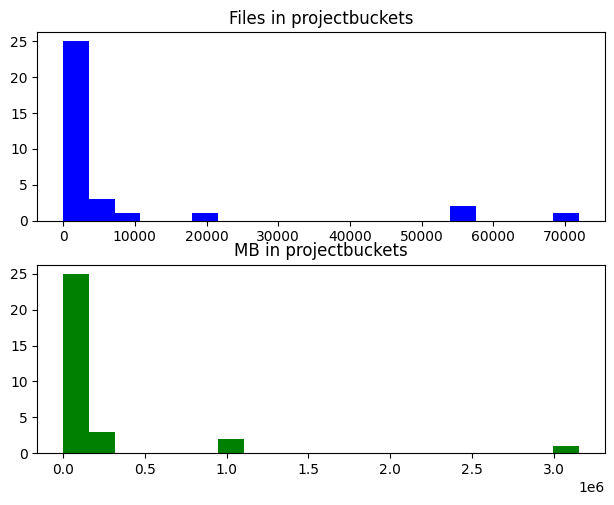

In [37]:
numPbFilesValues = np.sort(sto4ProjectBuckets[:,1].astype(np.int32))
numPbFilesValues = [x for x in numPbFilesValues if (x !=0)]

numPbSizeValues = np.sort(sto4ProjectBuckets[:,2].astype(np.int32))
numPbSizeValues = [x for x in numPbSizeValues if (x != 0)]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fig.tight_layout()

ax1.set_title('Files in projectbuckets')
ax1.hist(numPbFilesValues, bins=20, color='blue' )

ax2.set_title('MB in projectbuckets')
ax2.hist(numPbSizeValues, bins=20, color='green' )

plt.show()

We can see that there are a lot of small buckets that do not take up a lot of space. We can print the respective variables to see their numerical distribution.

In [38]:
print('{:<25} {:<10.0f}'.format('Non empty projectbuckets:', len(numPbFilesValues)))
print(numPbFilesValues)
print(numPbSizeValues)

Non empty projectbuckets: 33        
[1, 1, 7, 19, 27, 46, 59, 76, 84, 85, 87, 92, 106, 130, 158, 184, 241, 283, 373, 384, 425, 860, 1553, 1999, 3456, 5724, 5787, 5836, 8411, 19947, 54457, 57522, 71911]
[6, 65, 73, 109, 292, 377, 436, 593, 602, 661, 962, 1226, 1323, 2628, 4216, 5147, 8899, 13835, 17967, 20424, 24451, 56387, 89821, 107663, 112109, 243488, 264364, 271128, 1052654, 1094611, 3152748]


## Histogram of userbuckets
We can do the same for the userbuckets. Since we already know that many buckets are either empty, or contain little data, we firstly remove all empty buckets from the statistics, and then only show the distribution of the buckets that contain more files than the median of the non-empty buckets.

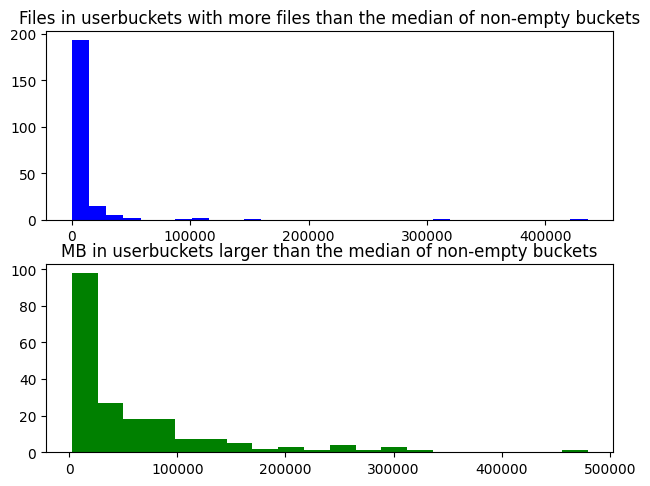

Non empty userbuckets:    196       
Median files non empty:   129.5     
Average files non empty:  5337.3    
Median MB non empty:      2534.5    
Average MB non empty:     28985.9   


In [39]:
if (len(sto4UserBuckets) > 0):
    numUbFilesValues     = np.sort(sto4UserBuckets[:,1].astype(np.int32))
    numUbFilesValues     = [x for x in numUbFilesValues if (x !=0)]
    medianFilesNonEmpty  = np.median(numUbFilesValues)
    averageFilesNonEmpty = np.average(numUbFilesValues)
    numUbFilesValues     = [x for x in numUbFilesValues if (x > medianFilesNonEmpty)]

    numUbSizeValues      = np.sort(sto4UserBuckets[:,2].astype(np.int32))
    numUbSizeValues      = [x for x in numUbSizeValues if (x != 0)]
    medianMbNonEmpty     = np.median(numUbSizeValues) 
    averageMbNonEmpty    = np.average(numUbSizeValues)
    numUbSizeValues      = [x for x in numUbSizeValues if (x > medianMbNonEmpty)]

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
    fig.tight_layout()

    ax1.set_title('Files in userbuckets with more files than the median of non-empty buckets')
    ax1.hist(numUbFilesValues, bins=30, color='blue' )

    ax2.set_title('MB in userbuckets larger than the median of non-empty buckets')
    ax2.hist(numUbSizeValues, bins='auto', color='green' )

    plt.show()

    # Print some statistics
    print('{:<25} {:<10.0f}'.format('Non empty userbuckets:', len(numUbSizeValues)))
    print('{:<25} {:<10.1f}'.format('Median files non empty:', medianFilesNonEmpty))
    print('{:<25} {:<10.1f}'.format('Average files non empty:', averageFilesNonEmpty))
    print('{:<25} {:<10.1f}'.format('Median MB non empty:', medianMbNonEmpty))
    print('{:<25} {:<10.1f}'.format('Average MB non empty:', averageMbNonEmpty))

## User and storage history
Now we want to see the development of users and storage usage over time. For this, we iterate through the daily reports to get the timestamps and statistics.

In [40]:
dailyFiles     = os.listdir(dailyDir)
detailedIndex  = np.char.find(dailyFiles, 'detailed')
detailedIndex  = (detailedIndex == -1)
summaryFiles   = np.sort(np.array(dailyFiles)[detailedIndex])

# Now we have the list of summary files and can iterate through it
dates = np.empty((0, len(summaryFiles)), str)
numUsers = np.empty((0, len(summaryFiles)), int)
usageGB = np.empty((0, len(summaryFiles)), int)

for summaryFile in summaryFiles:
    # We ignore hidden files that might have been created
    # Print . to indicate files are processing
    print('.', end='')
    if not summaryFile.startswith('.'):
        with open(dailyDir + summaryFile, 'r') as fin:
            summaryData = fin.read().splitlines(True)
            # Minimal error checking
            if (len(summaryData) == 3):
                ts = summaryData[0].split(' ')[0].removeprefix('DATE:')
                ts = datetime.strptime(ts, '%Y-%m-%d').date()
                dates = np.append(dates, ts)
                usageGB = np.append(usageGB, summaryData[2].split(';')[1])
                numUsers = np.append(numUsers, summaryData[2].split(';')[2])
                
# We convert users and usage to int32 to make it more easy to process later
usageGB = usageGB.astype(np.int32)
numUsers = numUsers.astype(np.int32)

# There is a small error where the number of users was reported as 0 or 1, we filter out those elements from the statistics
zeroUsersIndex = np.where(numUsers <= 1)[0]
dates = np.delete(dates, zeroUsersIndex)
numUsers = np.delete(numUsers, zeroUsersIndex)
usageGB = np.delete(usageGB, zeroUsersIndex)

............................................................................................................................................................................................................................................................................................................

Now that we have extracted all our data, we can visualize it in simple line diagrams.

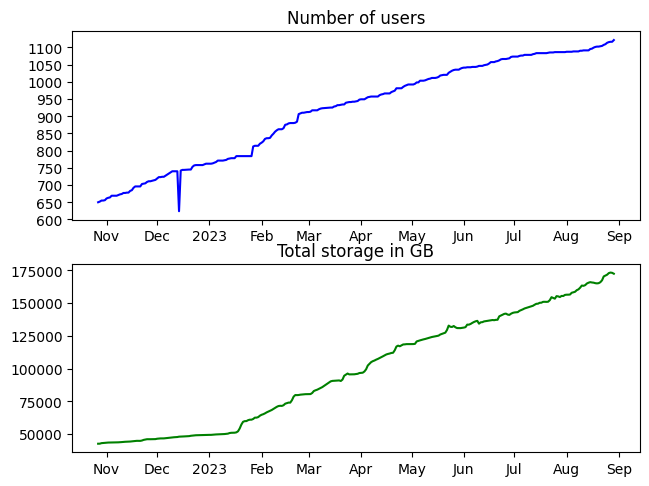

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, sharey=False)
fig.tight_layout()

ax1.set_title('Number of users')
ax1.set_yticks(np.arange(0, max(numUsers)+10, 50))
ax1.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax1.xaxis.get_major_locator()))

ax1.plot(dates, numUsers, color='blue')

ax2.set_title('Total storage in GB')
#ax2.set_xticks(np.arange(min(dates), max(dates), 30))

ax2.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))

ax2.plot(dates, usageGB, color='green' )

plt.show()

In [42]:
# Print some statistics
# We have to convert our datetime back to a string for proper formatting
firstReport = dates[0].strftime("%Y-%m-%d")
lastReport = dates[-1].strftime("%Y-%m-%d")
delta = dates[-1]-dates[0]
print('{:<25} {:<10}'.format('Users:', numUsers[-1]))
print('{:<25} {:<10}'.format('First report:', firstReport))
print('{:<25} {:<10}'.format('Last report:', lastReport))
print('{:<25} {:<10}'.format('Days:', delta.days))
print('{:<25} {:<10.0f}'.format('Total GB:', max(usageGB)))
print('{:<25} {:<10.1f}'.format('GB per day:', (max(usageGB)-min(usageGB))/delta.days))

Users:                    1121      
First report:             2022-10-27
Last report:              2023-08-29
Days:                     306       
Total GB:                 173284    
GB per day:               427.2     
